<a href="https://colab.research.google.com/github/marceloqs/VLDL_Tarea1/blob/main/Tarea1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jmsaavedrar/visual_attributes.git
!git clone https://github.com/jmsaavedrar/convnet2.git

In [ ]:
# Descargamos los datos y los descomprimimos
!mkdir -p /content/data/Resnet50
%cd /content/data/Resnet50

!wget https://www.dropbox.com/s/ri743kwqh8t6a7r/dataset_atributos.zip

!unzip dataset_atributos.zip

!rm dataset_atributos.zip

In [ ]:
# Generamos los catálogos con las rutas de las imágenes
import os
import pandas as pd
import sys

for set_name in ["color", "texture"]:
    print(f"Generando catálogos para {set_name} set ...")
    data_dir = os.path.join("/content/data/Resnet50/dataset_atributos/", set_name)

    # Leer todas las rutas de las imágenes y crear un DataFrame de pandas
    filenames = []
    for path, subdirs, files in os.walk(data_dir):
        for name in files:
            filenames.append(os.path.join(path, name))
    df = pd.DataFrame()
    df["filenames"] = filenames
    df = df.sample(frac=1)  # desordenar aleatoriamente todo el dataset

    for block_idx in range(1, 6):
        output_dir = f"/content/data/{set_name}/block_{block_idx}/ssearch"
        if not os.path.exists(output_dir):
            print(f"    Creando directorio para el bloque {block_idx} ...")
            os.makedirs(output_dir)
        output_fn = os.path.join(output_dir, "catalog.txt")
        df.to_csv(output_fn, header=False, index=False)

    for block_idx in range(1, 6):
        output_dir = f"/content/drive/MyDrive/Magister/VisualRecognitionDL/Tarea1/data/{set_name}/block_{block_idx}/ssearch"
        if not os.path.exists(output_dir):
            print(f"    Creando directorio en Drive para el bloque {block_idx} ...")
            os.makedirs(output_dir)

Generando catálogos para color set ...
    Creando directorio para el bloque 1 ...
    Creando directorio para el bloque 2 ...
    Creando directorio para el bloque 3 ...
    Creando directorio para el bloque 4 ...
    Creando directorio para el bloque 5 ...
Generando catálogos para texture set ...
    Creando directorio para el bloque 1 ...
    Creando directorio para el bloque 2 ...
    Creando directorio para el bloque 3 ...
    Creando directorio para el bloque 4 ...
    Creando directorio para el bloque 5 ...


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
%cd /content/visual_attributes

for set_name in ["color", "texture"]:
  print(f"Generando features para {set_name} set ...")
  for block_ixd in range(1, 6):
      netParam = "RESNET_{}_{}".format(set_name, block_ixd)
      print(netParam)
      !python ssearch.py -config config/resnet50.config -name $netParam -mode compute 


In [ ]:
# Respaldar el catálogo y los features obtenidos en Drive
#!cp -r /content/data/color/ /content/drive/MyDrive/Magister/VisualRecognitionDL/Tarea1/data/
#!cp -r /content/data/texture/ /content/drive/MyDrive/Magister/VisualRecognitionDL/Tarea1/data/

In [ ]:
# Cargamos el catálogo y los feature vectors obtenidos
import numpy as np
import pandas as pd

base_dir = "/content/data/color/block_1/ssearch"

features_shape = np.fromfile(f"{base_dir}/features_shape.np", dtype=np.int32)
features = np.fromfile(f"{base_dir}/features.np", dtype=np.float32)
features = np.reshape(features, features_shape)
print(f"Features shape = {features.shape}\n")

catalog_df = pd.read_csv(f"{base_dir}/catalog.txt", names=["filenames"])
print(f"Tamaño del DataFrame = {len(catalog_df)}")
catalog_df.head()

Features shape = (1000, 64)

Tamaño del DataFrame = 1000


,filenames
0,/content/data/Resnet50/dataset_atributos/color...
1,/content/data/Resnet50/dataset_atributos/color...
2,/content/data/Resnet50/dataset_atributos/color...
3,/content/data/Resnet50/dataset_atributos/color...
4,/content/data/Resnet50/dataset_atributos/color...


In [ ]:
def normalize(data) :
    # Normalizar los vectores para que sean unitarios
    norm = np.sqrt(np.sum(np.square(data), axis=1))
    norm = np.expand_dims(norm, 0)        
    data = data / np.transpose(norm)
    return data

def compute_ranking(fv):
    # Retorna un ranking ordenado, usando como criterio la similitud coseno.
    normalized_fv = normalize(fv)
    sim = np.matmul(normalized_fv, np.transpose(normalized_fv))
    idx_sorted = np.argsort(-sim, axis=-1)
    return idx_sorted

ranking = compute_ranking(features)
print(ranking.shape)

(1000, 1000)


In [ ]:
query_id = 6
print("query: {}".format(catalog_df.loc[query_id]["filenames"]))
print("Top 10 ranking:")
for idx in ranking[query_id][:10]:
    print("  {}".format(catalog_df.loc[idx]["filenames"]))

query: /content/data/Resnet50/dataset_atributos/color/morado/34.png
Top 10 ranking:
  /content/data/Resnet50/dataset_atributos/color/morado/34.png
  /content/data/Resnet50/dataset_atributos/color/morado/29.png
  /content/data/Resnet50/dataset_atributos/color/morado/28.png
  /content/data/Resnet50/dataset_atributos/color/morado/36.png
  /content/data/Resnet50/dataset_atributos/color/morado/7.png
  /content/data/Resnet50/dataset_atributos/color/morado/94.png
  /content/data/Resnet50/dataset_atributos/color/morado/17.png
  /content/data/Resnet50/dataset_atributos/color/morado/41.png
  /content/data/Resnet50/dataset_atributos/color/morado/20.png
  /content/data/Resnet50/dataset_atributos/color/morado/100.png


In [ ]:
import matplotlib.pyplot as plt
from skimage import io

def plot_top_10(ranking, query_id, df):
    query_img = io.imread(df.loc[query_id]["filenames"])

    fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(15, 2))
    ax[0].imshow(query_img, cmap='gray')
    ax[0].set_title("query")

    for i in range(0, 10):
        elem = ranking[query_id][i]
        img = io.imread(df.loc[elem]["filenames"])
        ax[i + 1].imshow(img, cmap='gray')
        ax[i + 1].set_title(f"rank = {i}")

    for i in range(11):
        ax[i].set_xticks([])
        ax[i].set_yticks([])

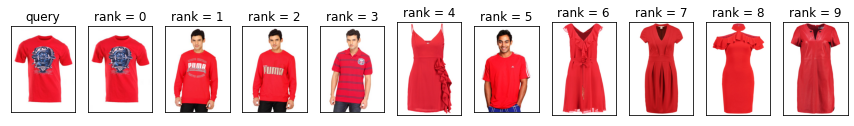

In [ ]:
plot_top_10(ranking, 1, catalog_df)

In [ ]:
# Instalar UMAP
!pip install umap-learn[plot]

In [ ]:
import plotly.express as px
import umap

# Reducir dimensionalidad con UMAP
features_2d = umap.UMAP().fit_transform(features)
print(features_2d.shape)

(1000, 2)


In [ ]:
catalog_df.loc[:, "color"] = catalog_df["filenames"].str.split('/',expand=True)[6]

In [ ]:
# Graficar los resultados
catalog_df.loc[:, "x"] = features_2d[:, 0]
catalog_df.loc[:, "y"] = features_2d[:, 1]

In [ ]:
def get_scatter(fig_df, color_col):
    fig = px.scatter(
        fig_df,
        x="x",
        y="y",
        color=color_col,
        hover_name="color",
        hover_data=[
        "filenames"
    ],
    height=800,
    width=800
    )
    return fig

In [ ]:
get_scatter(catalog_df, catalog_df.loc[:, "color"])